<a href="https://colab.research.google.com/github/kmalicekim/NLP_practice_mine/blob/master/12.%20CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 12. CNN을 이용한 문서 분류

### 12.1 NLTK 영화 리뷰 데이터 변환

In [6]:
import nltk
nltk.download('movie_reviews')

from nltk.corpus import movie_reviews
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from sklearn.model_selection import train_test_split 

# movie review data에서 file id를 가져옴
fileids = movie_reviews.fileids() 

# file id를 이용해 raw text file을 가져옴 
reviews = [movie_reviews.raw(fileid) for fileid in fileids]
categories = [movie_reviews.categories(fileid)[0] for fileid in fileids] 

np.random.seed(7)
tf.random.set_seed(7)

max_words = 10000  # 사용할 단어의 수
maxlen = 500       # 문서의 단어 수를 제한 


# 빈도가 높은 10000개의 단어를 선택하도록 객체 생성
tokenizer = Tokenizer(num_words=max_words, oov_token='UNK')

# 단어 인덱스 구축
tokenizer.fit_on_texts(reviews)   

# 만들어진 단어 인덱스를 이용해 변환
X = tokenizer.texts_to_sequences(reviews)
X = pad_sequences(X, maxlen=maxlen, truncating='pre') 

# label을 0,1의 값으로 변환
label_dict = {'pos':0, 'neg':1}
y = np.array([label_dict[c] for c in categories]) 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)


[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


## 12.2 CNN 모형 생성 및 학습

In [7]:
from tensorflow.keras.models import Sequential  
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D 
from tensorflow.keras.layers import Embedding, Dropout, Flatten 
from tensorflow.keras.optimizers import Adam 

model = Sequential([
    Embedding(max_words, 64, input_length=maxlen),
    Conv1D(128,    #채널의 수
           5,      #1D 필터 크기
           padding='valid',
           activation='relu',
           strides=1),
    MaxPooling1D(),
    Conv1D(256,
           5,
           padding='valid',
           activation='relu',
           strides=1),
    MaxPooling1D(),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')   #binary logistic regression 수행
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 64)           640000    
                                                                 
 conv1d (Conv1D)             (None, 496, 128)          41088     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 248, 128)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 244, 256)          164096    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 122, 256)         0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 31232)             0

In [8]:
adam = Adam(learning_rate=1e-3)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['acc']) 
history = model.fit(X_train, y_train,
                    epochs=20,
                    batch_size=256,
                    verbose=1,
                    validation_split=0.2)

Epoch 1/20
5/5 [==============================] - 14s 2s/step - loss: 0.7183 - acc: 0.5289 - val_loss: 0.6940 - val_acc: 0.4969
Epoch 2/20
5/5 [==============================] - 12s 2s/step - loss: 0.6933 - acc: 0.4969 - val_loss: 0.6931 - val_acc: 0.4969
Epoch 3/20
5/5 [==============================] - 12s 2s/step - loss: 0.6926 - acc: 0.4969 - val_loss: 0.6928 - val_acc: 0.4969
Epoch 4/20
5/5 [==============================] - 12s 2s/step - loss: 0.6919 - acc: 0.5102 - val_loss: 0.6923 - val_acc: 0.5094
Epoch 5/20
5/5 [==============================] - 12s 2s/step - loss: 0.6898 - acc: 0.5703 - val_loss: 0.6920 - val_acc: 0.4969
Epoch 6/20
5/5 [==============================] - 13s 2s/step - loss: 0.6844 - acc: 0.6906 - val_loss: 0.6905 - val_acc: 0.5719
Epoch 7/20
5/5 [==============================] - 12s 2s/step - loss: 0.6706 - acc: 0.8148 - val_loss: 0.6848 - val_acc: 0.5437
Epoch 8/20
5/5 [==============================] - 12s 2s/step - loss: 0.6433 - acc: 0.7352 - val_loss: 0

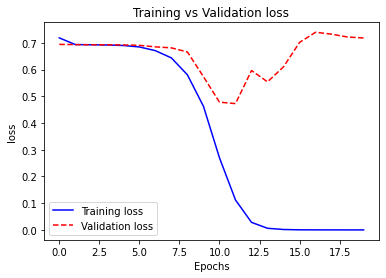

13/13 [==============================] - 2s 151ms/step - loss: 0.6988 - acc: 0.8150
#Test accuracy: 0.815


In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_results(history, metric):
  plt.plot(history.history[metric], 'b', label='Training '+metric)
  plt.plot(history.history['val_'+metric], 'r--', label='Validation '+metric)
  plt.title('Training vs Validation '+metric)
  plt.xlabel('Epochs')
  plt.ylabel(metric)
  plt.legend()
  plt.show()

plot_results(history, 'loss')

# 테스트 셋으로 학습된 모형의 성능을 평가
score = model.evaluate(X_test, y_test)
print(f'#Test accuracy: {score[1]:.3f}')